tabela de chance minima de contaminação.
     mes      2010      2011      2012      2013      2014      2015      2016  \
0     1  0.132868  0.153139  0.135465  0.090654  0.090207  0.077823  0.099015   
1     2  0.165938  0.108011  0.178039  0.080361  0.077749  0.071623  0.096204   
2     3  0.139463  0.093209  0.141088  0.087508  0.085191  0.083544  0.093818   
3     4  0.152660  0.113747  0.128772  0.096037  0.087139  0.090097  0.079025   
4     5  0.158956  0.121834  0.148450  0.117797  0.119524  0.103304  0.083593   
5     6  0.168555  0.182856  0.175907  0.115327  0.106404  0.126854  0.074689   
6     7  0.168307  0.188657  0.165995  0.118098  0.137748  0.135584  0.079720   
7     8  0.137980  0.208327  0.168764  0.098714  0.121446  0.137843  0.091958   
8     9  0.115025  0.173477  0.118738  0.089827  0.110263  0.152118  0.100473   
9    10  0.120692  0.168801  0.105830  0.086885  0.101194  0.111898  0.105254   
10   11  0.153207  0.162864  0.133264  0.074933  0.088468  0.106244

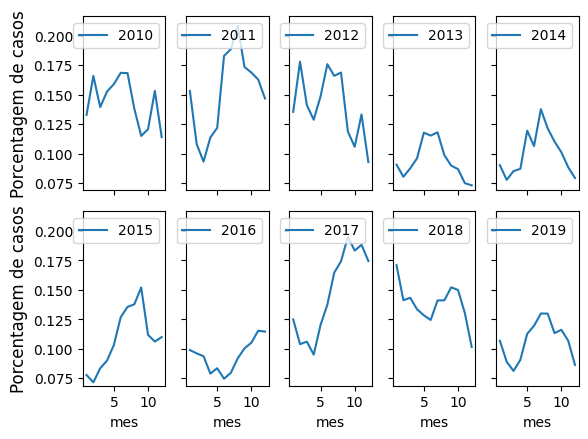


Matriz normalizada

         mes      2010      2011      2012      2013      2014      2015  \
0  -1.525426 -0.547805  0.037192 -0.204526 -0.218899 -0.537228 -1.220264   
1  -1.248075  1.083505 -1.222232  1.342143 -0.871682 -1.194707 -1.463609   
2  -0.970725 -0.222511 -1.635330 -0.000264 -0.418401 -0.801902 -0.995731   
3  -0.693375  0.428499 -1.062147 -0.447680  0.122500 -0.699118 -0.738508   
4  -0.416025  0.739105 -0.836457  0.267215  1.502538  1.010024 -0.220154   
5  -0.138675  1.212624  0.866536  1.264707  1.345883  0.317599  0.704184   
6   0.138675  1.200390  1.028456  0.904592  1.521597  1.971830  1.046842   
7   0.416025 -0.295648  1.577385  1.005189  0.292302  1.111485  1.135517   
8   0.693375 -1.428022  0.604812 -0.812227 -0.271337  0.521267  1.695793   
9   0.970725 -1.148487  0.474293 -1.281150 -0.457907  0.042646  0.117162   
10  1.248075  0.455500  0.308599 -0.284476 -1.215864 -0.629000 -0.104756   
11  1.525426 -1.477152 -0.141108 -1.753522 -1.330730 -1.112896  0.0

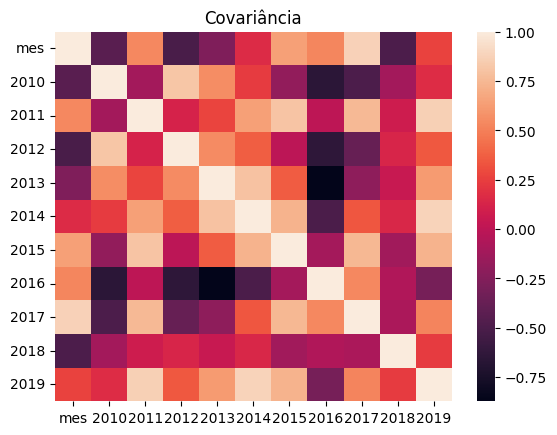

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def importar():
    """importa os dados necessários e devolve dois dados: tabela da malária e dados dos municípios
    arg: nenhum
    retunr: df =  tabela pandas para base de dados e municipios = tabela pandas dos municipios e da população por ano."""
    df = pd.read_pickle("dados\Dados_utilizaveis")
    # criar coluna com dados de casos confirmados como 1, outros resultados como 0
    df["detection.numerico"] = df["detection.type"].map(
        {"active": 1, "passive": 0, "CVL": 0}
    )
    municipio = pd.read_pickle("dados\municipio")
    municipio["id_municipio"] = (
        municipio["id_municipio"] // 10
    )  # Tirado ultimo digito do ID para facilitar seu uso, pois não possue diferencia retirar esse digito para o uso final.
    return df, municipio


def municipios_unicos(df, year):
    """Descobre municípios relatados em cada ano, não repetindo-os
    arg: base de dados e de ano em questão
    return: matriz dos municípios em cada mês do ano"""
    logic = df["notification.year"] == year
    municipio_unico_cada_mes = (
        df.loc[logic].groupby("notification.month")["infection.county"].unique()
    )
    return municipio_unico_cada_mes


def descobrir_população_por_mes(
    municipio, municipio_unico_cada_mes, ano, tabela_população
):
    """Descobre a polulação total de cada mês
    Arg: tabela de dados de município, tabela de dados de município único, ano de referência, tabela de população para adicionar dados novos
    Return: tabela, com primeira colula dos meses e segunda, da população total; com referência ao ano"""
    # todas as colunas do respectivo ano
    logic1 = municipio["ano"] == ano
    mes = 0
    lista_população = []
    # for em cada linha
    for linha in municipio_unico_cada_mes:
        mes += 1
        população_total = 0
        # for id em cada lista de municipios
        for id in linha:
            logic2 = municipio["id_municipio"] == id
            população_total += int(municipio.loc[logic1 & logic2]["populacao"])
        lista_população.append(população_total)
    tabela_população[f"{ano}"] = lista_população

    return tabela_população


def descobrir_casos_por_mes(df, ano, tabela_casos):
    """Descobre a soma dos casos por mes de determinado ano usando groupby pela sua rapidez
    Arg: dados, ano em questão, tabela de casos para add dados
    Return: tabela de casos"""
    logic = df["notification.year"] == ano
    casos_cada_mes = list(
        df.loc[logic].groupby("notification.month")["detection.numerico"].sum()
    )
    tabela_casos[f"{ano}"] = casos_cada_mes
    return tabela_casos


def plot_graficos(tabela_plot):
    fig = plt.figure()  # Definindo a figura do plot

    ax1 = fig.add_subplot(251)
    tabela_plot.plot(x="mes", y="2010", legend=True, ax=ax1)
    ax1.set_ylabel("Porcentagem de casos", fontsize=12)
    ax1.set_xlabel("")
    ax1.set_xticklabels([])

    ax2 = fig.add_subplot(252)
    tabela_plot.plot(x="mes", y="2011", legend=True, ax=ax2)
    ax2.set_yticklabels([])
    ax2.set_xticklabels([])
    ax2.set_xlabel("")

    ax3 = fig.add_subplot(253)
    tabela_plot.plot(x="mes", y="2012", legend=True, ax=ax3)
    ax3.set_yticklabels([])
    ax3.set_xticklabels([])
    ax3.set_xlabel("")

    ax4 = fig.add_subplot(254)
    tabela_plot.plot(x="mes", y="2013", legend=True, ax=ax4)
    ax4.set_yticklabels([])
    ax4.set_xticklabels([])
    ax4.set_xlabel("")

    ax5 = fig.add_subplot(255)
    tabela_plot.plot(x="mes", y="2014", legend=True, ax=ax5)
    ax5.set_yticklabels([])
    ax5.set_xticklabels([])
    ax5.set_xlabel("")

    ax6 = fig.add_subplot(256)
    tabela_plot.plot(x="mes", y="2015", legend=True, ax=ax6)
    ax6.set_ylabel("Porcentagem de casos", fontsize=12)

    ax7 = fig.add_subplot(257)
    tabela_plot.plot(x="mes", y="2016", legend=True, ax=ax7)
    ax7.set_yticklabels([])

    ax8 = fig.add_subplot(258)
    tabela_plot.plot(x="mes", y="2017", legend=True, ax=ax8)
    ax8.set_yticklabels([])

    ax9 = fig.add_subplot(259)
    tabela_plot.plot(x="mes", y="2018", legend=True, ax=ax9)
    ax9.set_yticklabels([])

    ax10 = fig.add_subplot(2, 5, 10)
    tabela_plot.plot(x="mes", y="2019", legend=True, ax=ax10)
    ax10.set_yticklabels([])

    plt.subplots_adjust(wspace=0.25, hspace=0.12)  # Ajustar distância entre os gráficos
    plt.subplots_adjust(wspace=0.25, hspace=0.12)  # Ajustar distância entre os gráficos

    for ax in [
        ax1,
        ax2,
        ax3,
        ax4,
        ax5,
        ax6,
        ax7,
        ax8,
        ax9,
        ax10,
    ]:  # Ajustar o range dos eixos-y de todos os gráficos, para uniformizar
        itens = [str(i)for i in range(2010,2020)] #lista para pegar apenas itens corretos
        numero_maximo = tabela_plot[itens].max().max()
        valor_minimo = tabela_plot[itens].min().min()
        plt.setp(ax, ylim=(valor_minimo-(valor_minimo/25),numero_maximo+(numero_maximo/25)))

    plt.savefig(
        "grafico.png", dpi=300, format="png", facecolor="white"
    )  # Salvar figura com o gráfico, fundo branco
    plt.show()  # Mostrar o gráfico


def matriz_covariancia(df):
    df["mes"] = normalizar(df, "mes")
    for i in range(2010, 2020):
        df[str(i)] = normalizar(df, str(i))
    print("\nMatriz normalizada\n")
    print(df)
    print("\nMatriz de covariancia.\n")
    matriz = df.cov()
    print(matriz)
    sns.heatmap(matriz, xticklabels=matriz.columns, yticklabels=matriz.columns)
    plt.title("Covariância")
    plt.savefig(
        "matriz_covariancia.png", dpi=300, format="png", facecolor="white"
    )  # Salvar figura com o gráfico, fundo branco
    plt.show()


def normalizar(df, coluna):
    return (df[coluna] - df[coluna].mean()) / df[coluna].std()


def descricao(df):
    print("Descrição da tablela de chance minima de contaminação.\n")
    tabela_descricao = df.describe()
    print(tabela_descricao)


def main():
    """Função padrão para organizar o codigo"""
    df, municipio = importar()
    # tabelas previamente criada para organizar dados
    tabela_população = pd.DataFrame(
        [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], columns=["mes"]
    )
    tabela_casos = pd.DataFrame(
        [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], columns=["mes"]
    )
    # Um ano a menos do que poderia pois não temos dados da população de todas os munucipios
    for ano in range(2010, 2020):
        municipio_unico_cada_mes = municipios_unicos(df, ano)
        tabela_população = descobrir_população_por_mes(
            municipio, municipio_unico_cada_mes, ano, tabela_população
        )
        tabela_casos = descobrir_casos_por_mes(df, ano, tabela_casos)
    tabela_chance = (
        tabela_casos / tabela_população * 100
    )  # tabela de percentagem da chance
    tabela_chance["mes"] = list(range(1, 13))  # Arrumando a coluna mês
    print("tabela de chance minima de contaminação.\n", tabela_chance)
    descricao(tabela_chance)
    plot_graficos(tabela_chance)
    matriz_covariancia(tabela_chance)


main()


In [4]:
from sklearn.model_selection import train_test_split

df, municipio = importar()

TAMANHO_TESTE = 0.05

indices = df.index
indices_treino, indices_teste = train_test_split(
    indices, test_size=TAMANHO_TESTE
)

df_treino = df.loc[indices_treino]
df_teste = df.loc[indices_teste]

print(df_treino)
print()
print(df_teste)

         infection.county             infection.hr       occupation  \
827909           130120.0     RIO NEGRO E SOLIMOES            other   
2164544          150195.0               RIO CAETES  domestic worker   
2317578          150360.0                  TAPAJOS          panning   
1391247          130280.0                TRIANGULO            other   
452077           120033.0  JURUA E TARAUACA/ENVIRA      agriculture   
...                   ...                      ...              ...   
1980919          150070.0                MARAJO II            other   
2463884          150503.0                  TAPAJOS          panning   
39887            110020.0           MADEIRA-MAMORE            other   
1622370          130390.0            ALTO SOLIMOES            other   
480326           120033.0  JURUA E TARAUACA/ENVIRA      agriculture   

        detection.type infection.state  notification.month  notification.year  \
827909          active              AM                 6.0        